## Requirement 1: Stochatic Environment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

c:\Users\39327\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\39327\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\39327\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Stochastic Pricing Environment

In [3]:
class StochasticPricingEnvironment:
    def __init__(self, model='linear', alpha=None, beta=None):
        self.model = model
        self.alpha = alpha
        self.beta = beta
        np.random.seed(42)


    # given settled price and number customer
    # returns a sample of number of sale and profit
    def round(self, price_t, n_costumer_t):
        # number of sale at time t
        number_sale_t = np.random.binomial(n_costumer_t, StochasticPricingEnvironment.generate_probability(self.model, self.alpha, self.beta, price_t))

        return number_sale_t

    # takes as input the selling price -> [0,1]
    # return as output the probability of selling -> [0,1]
    @staticmethod
    def generate_probability(model, a, b, price):
        def isNotNone(s,d):
            if s is None:
                return d
            else:
                return s
        global purchase_probabilities
        if model == 'linear':
            alpha = isNotNone(a, 1) # Intercept
            beta = isNotNone(b, -1)  # Slope
            purchase_probabilities = alpha + beta * price
            
        elif model == 'logistic':
            alpha = isNotNone(a, 0)
            beta = isNotNone(b, -5)
            purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta * price)))
            
        elif model == 'probit':
            alpha = isNotNone(a, 0)
            beta = isNotNone(b, -5)
            purchase_probabilities = norm.cdf(alpha + beta * price)
            
        elif model == 'KERNEL':
            purchase_probabilities = np.abs(np.sin(2 * np.pi * price) * np.exp(-price * 5) + price * .10) + .1

        return purchase_probabilities


### Pricing Agent : Gaussian Process Agent with RBF kernel and UCB algorithm

In [4]:
# Radial Basis Function Kernel
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [5]:
# From the agent's point of view, action set is [0,1]. 
# If the actual actions are outside this set, perform rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, minimum_price=0, maximum_price=1, scale=0.1, discretization=None):
        self.T = T
        if(discretization is None):
            # discretization prescribed by theory
            epsilon = T**(-0.33)
            discretization = int(1/epsilon)
        self.minimum_price = minimum_price
        self.maximum_price = maximum_price
        self.arms = np.linspace(minimum_price, maximum_price, discretization)
        self.N_pulls = np.zeros(discretization)
        self.average_bidding_costs = np.zeros(discretization)
        self.average_customer_percentages = np.ones(discretization)
        self.gp = RBFGaussianProcess(scale=scale).fit()
        self.a_t = None
        self.action_hist = []
        self.reward_hist = []
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.t = 0
    
    def pull_arm(self, verbose=False):
        # play every arm at least once
        if self.t < len(self.arms):
            self.a_t = self.t
            return self.arms[self.a_t],1,self.average_bidding_costs[self.a_t]
        else:
            # averages of GP  +  estimation uncertainty  -> purchase probability
            self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
            purchase_probabilities = self.mu_t + self.beta(self.t) * self.sigma_t
            # estimated profit per customer of each price
            estimated_profits_per_customer = purchase_probabilities * self.arms - self.average_bidding_costs
            # estimated total profit of each price
            ucbs = estimated_profits_per_customer * self.average_customer_percentages
            self.a_t = np.argmax(ucbs)
            if(verbose):
                print(purchase_probabilities)
                print(self.arms - self.average_bidding_costs)
                print(estimated_profits_per_customer)
                print(self.average_customer_percentages)
                print(ucbs)
            return self.arms[self.a_t], purchase_probabilities[self.a_t], self.average_bidding_costs[self.a_t]
    
    def update(self, n_sales_t, n_customers_t, bidding_cost_per_customer_t=0, customer_percentage=1):
        self.N_pulls[self.a_t] += 1
        self.average_bidding_costs[self.a_t] += (bidding_cost_per_customer_t - self.average_bidding_costs[self.a_t])/self.N_pulls[self.a_t]
        # probability of winning customers of arm
        self.average_customer_percentages[self.a_t] += (customer_percentage - self.average_customer_percentages[self.a_t])/self.N_pulls[self.a_t]
        # purchase probability of arm
        estimated_purchase_probability = 0
        if(n_customers_t != 0):
            estimated_purchase_probability = n_sales_t / n_customers_t
        self.gp = self.gp.fit(self.arms[self.a_t], estimated_purchase_probability)
        self.t += 1
        self.action_hist.append(self.arms[self.a_t])
        self.reward_hist.append((self.arms[self.a_t]-self.minimum_price)*n_sales_t - bidding_cost_per_customer_t*n_customers_t)


In [6]:
# UCB1 agent for performance comparison
class UCB1Agent:
    def __init__(self, T, K=None, range=1):
        if K is None:
            # prescribed by theory
            epsilon = T**(-0.33)
            K = int(1/epsilon)
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t, verbose = False):
        if verbose:
            print(f'updating arm {self.a_t} with reward {r_t} average reward : {self.average_rewards[self.a_t]:.2f} -> {(self.average_rewards[self.a_t] + (r_t - self.average_rewards[self.a_t])/(self.N_pulls[self.a_t]+1)):.2f}')
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### Bidding Environment

In [7]:
class SecondPriceAuction:
    def __init__(self, ctrs):
        # ctr = click though rate = lambda * q
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        # sort not by bids, but estimated values
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)
    
    def round(self, bids):
        # given bids, return winner(s) and the estimated values (product of 3 terms : lambda, q, bid) of winner(s)
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [8]:
class UniformBiddingEnvironment:
    def __init__(self, T, n_advertisers, auction, seed=42):
        self.T = T
        self.auction = auction
        self.n_advertisers = n_advertisers
        np.random.seed(seed)
        self.other_bids = np.random.uniform(0, 1, size = (n_advertisers, T))
        self.m_t = self.other_bids.max(axis=0)

    def round(self, round, bid):
        bids_at_round = np.append(self.other_bids[:, round], bid)
        winners, payments_per_click = self.auction.round(bids=bids_at_round)
        return winners, self.m_t[round]
    
    def get_clairvoyant_truthful(self, B, my_valuation):
        ## I compute my sequence of utilities at every round
        utility = (my_valuation-self.m_t)*(my_valuation>=self.m_t)
        #   if valuation less than max_bid of the round, no need to participate
        #   if higher, utility is the difference

        ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
        ## In second price auctions, I can find the sequence **greedily**:
        sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
        clairvoyant_utilities = np.zeros(self.T)
        clairvoyant_bids= np.zeros(self.T)
        clairvoyant_payments = np.zeros(self.T)
        c = 0
        i = 0
        #    (enough budget) and (examined all rounds)
        while c <= B-1 and i < self.T and i < np.count_nonzero(utility):
            clairvoyant_bids[sorted_round_utility[i]] = 1  # simply bid 1 because we are in second-price auction
            clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
            clairvoyant_payments[sorted_round_utility[i]] = self.m_t[sorted_round_utility[i]]
            c += self.m_t[sorted_round_utility[i]]  # cost is incremented by second price of that round
            i+=1
        return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

### Bidding Agents

#### Primal-dual algorithm -> Multiplicative Pacing

In [9]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1  # shouldn't this be initialized with 0?
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

#### Alternative Multiplicative Pacing -> continuously updated Rho
Idea behind is that normal MP generally does not deplete budget, so update every round the budget per round 

In [10]:
class ContinuousUpdatedRhoMPAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.rho = 1.*self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.t += 1
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t
        if(self.t<self.T):
            self.rho = self.budget/(self.T-self.t)

#### UCB-like algorithm -> simple UCB

In [11]:
class UCBAgent:
    def __init__(self, valuation, budget, T, K=100, range=1):
        self.T = T
        self.valuation = valuation
        self.budget = budget
        self.K = K
        self.range = range
        self.arms = np.linspace(0, valuation, K)
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.a_t = None
        self.t = 0

    def bid(self):
        # if budget depleted
        if self.budget < 1:
            return 0
        
        # play every arm at least once
        if self.t < self.K:
            self.a_t = self.t
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]

    def update(self, f_t, c_t):
        self.t += 1
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (f_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t

#### UCB-like algorithm -> UCB with negative feedback when not winning (lost opportunity)
lost opportunity computed as average utility when winning

In [12]:
class UCBNFAgent:
    def __init__(self, valuation, budget, T, K=None, range=1):
        self.T = T
        self.valuation = valuation
        self.budget = budget
        if K is None:
            # prescribed by theory
            epsilon = T**(-0.33)
            K = int(1/epsilon)
        self.K = K
        self.range = range
        self.arms = np.linspace(0, valuation, K)
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.winning_total_reward = 0
        self.won_time = 0
        self.a_t = None
        self.t = 0

    def bid(self):
        # if budget depleted
        if self.budget < 1:
            return 0
        
        # play every arm at least once
        if self.t < self.K:
            self.a_t = self.t
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
            # if(self.t<50):
            #     print(f'round {self.t} : {ucbs}\n bidded {self.arms[self.a_t]} with ucb={ucbs[self.a_t]}')
        return self.arms[self.a_t]

    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        
        if(f_t>0):
            self.won_time += 1
            self.winning_total_reward += f_t
        elif(self.t >= self.K):
            f_t = - (self.winning_total_reward / self.won_time)
    
        self.average_rewards[self.a_t] += (f_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

### Simulation

In [42]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

np.random.seed(2)

# product 
min_price, max_price = 10, 20
production_cost = 10
price_discretization = 20
payed_bid_per_user = 0
scaled_payed_bid_per_user = 0
scaled_min_price = MinMaxScaler(min_price, min_price, max_price)
scaled_max_price = MinMaxScaler(max_price, min_price, max_price)
scaled_cost = MinMaxScaler(production_cost, min_price, max_price)  # equals to scaled_min_price

# Pricing Environment and Agent
# Logistic model example
model='logistic'
alpha=0.8
beta=-3
scale=2
TotalDays = 365
pricing_env = StochasticPricingEnvironment(model, alpha, beta)
pricing_agent = GPUCBAgent(TotalDays, scaled_min_price, scaled_max_price, discretization=price_discretization, scale=scale)
n_customers_t = 0        # to be determined every day after bidding
# for clairvoyant's use
prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)


# Bidding Environment parameters
n_users = 10000
n_competitors = 2
ctrs = np.ones(n_competitors+1)
B = 100
auction = SecondPriceAuction(ctrs)
bidding_agent_profits = []
clairvoyant_profits = []

# Foreach day
for day in range(TotalDays):
    # pricing agent sets the price of the day
    p_t, purchase_probability_t, average_bid_cost_t = pricing_agent.pull_arm()

    # Bidding Environment
    bidding_env = UniformBiddingEnvironment(n_users, n_competitors, auction, seed=day)

    # Bidding Agents
    my_valuation_t = p_t*purchase_probability_t # equals to daily_set_price (which took into account the production cost)

    # Exploratory round to estimate the purchase probability of each price
    if(day == 0):
        my_valuation_t = scaled_max_price
    
    
    eta = 1/np.sqrt(n_users) # from theory
    agentMP = MultiplicativePacingAgent(valuation=my_valuation_t,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)
    # agentCURMP = ContinuousUpdatedRhoMPAgent(valuation=my_valuation_t,
    #                                 budget=B,
    #                                 T=n_users, 
    #                                 eta=eta)
    # agentUCB = UCBAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF = UCBNFAgent(my_valuation_t, B, n_users, range=my_valuation_t/2)
    # agentNF1 = UCBNFAgent(my_valuation_t, B, n_users, range=0.1)    # range works as the hyperparameter in this problem
    
    bidding_agents = {
        "Multiplicative Pacing": agentMP,
        # "Continuously updated Rho MP": agentCURMP,
        # "Plain UCB": agentUCB,
        # "UCB with negative feedback": agentNF,
        # "UCBNF with range 0.1" : agentNF1
    }

    utilities = np.zeros((len(bidding_agents), n_users))
    my_bids = np.zeros((len(bidding_agents), n_users))
    my_payments = np.zeros((len(bidding_agents), n_users))
    total_wins = np.zeros((len(bidding_agents)))
    bidding_agent_profit=0
    number_sale_t=0

    np.random.seed(day)
    for u in range(n_users):
        # bidding process
        for idx, (name, agent) in enumerate(bidding_agents.items()):
            my_bid = agent.bid()
            winners, m_t = bidding_env.round(u, my_bid)
            my_win = int(winners==n_competitors)
            f_t, c_t = (my_valuation_t-m_t)*my_win, m_t*my_win
            agent.update(f_t, c_t)
            utilities[idx,u] = f_t
            my_bids[idx,u] = my_bid
            my_payments[idx,u] = c_t
            total_wins[idx] += my_win
    if(total_wins[0] != 0):
        n_customers_t = total_wins[0]
        scaled_payed_bid_per_user = np.sum(my_payments[0,:]) / total_wins[0]
    
    
    # Update pricing agent
    # Exploratory round to estimate purchase probability
    if(day == 0):
        original_a_t = pricing_agent.a_t
        customers_per_price = int(n_customers_t / price_discretization)
        for idx, price in enumerate(pricing_agent.arms):
            sales_per_price = pricing_env.round(price, customers_per_price)
            pricing_agent.a_t = idx
            pricing_agent.update(sales_per_price, customers_per_price)
            # print(f'Price # {idx} : {price} with {sales_per_price}/{customers_per_price} sales')
        pricing_agent.a_t = original_a_t
    # Normal rounds
    else:
        number_sale_t = pricing_env.round(p_t, n_customers_t)
        pricing_agent.update(number_sale_t, n_customers_t, scaled_payed_bid_per_user, n_customers_t/n_users)
        bidding_agent_profit = number_sale_t*p_t-np.sum(my_payments[0,:])
        bidding_agent_profits.append(bidding_agent_profit)

    # Clairvoyant utilities
    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = bidding_env.get_clairvoyant_truthful(B, p_t*conversion_probabilities[pricing_agent.a_t])
    clairvoyant_customers = np.count_nonzero(clairvoyant_bids)
    clairvoyant_sales =  int(clairvoyant_customers * conversion_probabilities[pricing_agent.a_t])
    clairvoyant_profit = clairvoyant_sales*p_t - np.sum(clairvoyant_payments)
    if(clairvoyant_profit <=0 and day>0):
        print("Total revenue :")
        print(number_sale_t*p_t)
        print(clairvoyant_sales*p_t)

        print("Total payment :")
        print(np.sum(my_payments[0,:]))
        print(np.sum(clairvoyant_payments))

        print("Total won auction :")
        print(np.count_nonzero(my_payments[0,:]))
        print(np.count_nonzero(clairvoyant_payments))

        print("Mean payed bid :")
        print(np.sum(my_payments[0,:])/np.count_nonzero(my_payments[0,:]))
        print(np.sum(clairvoyant_payments)/np.count_nonzero(clairvoyant_payments))
        break
    clairvoyant_profits.append(clairvoyant_profit)

    # logging
    if(n_customers_t == 0):
        n_customers_t=1
    if(clairvoyant_customers == 0):
        clairvoyant_customers=1
    print(f'At day {day} :\tprice_t = {p_t:.4f}, with estimated purchase probability = {purchase_probability_t:.4f}\
          \n\t\tmy valuation = {my_valuation_t:.4f}, won {int(n_customers_t)}/{n_users} auctions, with a mean bid of {scaled_payed_bid_per_user:.4f} \
          \n\t\twe sold {number_sale_t}/{int(n_customers_t)} ({number_sale_t/n_customers_t*100:.2f}%) products, for a total net profit of {bidding_agent_profit:.4f}\
          \n\t\tclairvoyant sale : {clairvoyant_sales}/{clairvoyant_customers} ({clairvoyant_sales/clairvoyant_customers*100:.2f}%), for a total net profit of {clairvoyant_profit:.4f}\n')
    n_customers_t=0
    clairvoyant_customers=0


At day 0 :	price_t = 0.0000, with estimated purchase probability = 1.0000          
		my valuation = 1.0000, won 349/10000 auctions, with a mean bid of 0.2842           
		we sold 0/349 (0.00%) products, for a total net profit of 0.0000          
		clairvoyant sale : 0/1 (0.00%), for a total net profit of 0.0000

At day 1 :	price_t = 0.4737, with estimated purchase probability = 0.4088          
		my valuation = 0.1936, won 172/10000 auctions, with a mean bid of 0.0919           
		we sold 62/172 (36.05%) products, for a total net profit of 13.5696          
		clairvoyant sale : 95/273 (34.80%), for a total net profit of 14.7007

At day 2 :	price_t = 0.4211, with estimated purchase probability = 0.4503          
		my valuation = 0.1896, won 177/10000 auctions, with a mean bid of 0.0868           
		we sold 78/177 (44.07%) products, for a total net profit of 17.4766          
		clairvoyant sale : 106/276 (38.41%), for a total net profit of 15.0051

At day 3 :	price_t = 0.5263, with esti

(365,)
(364,)


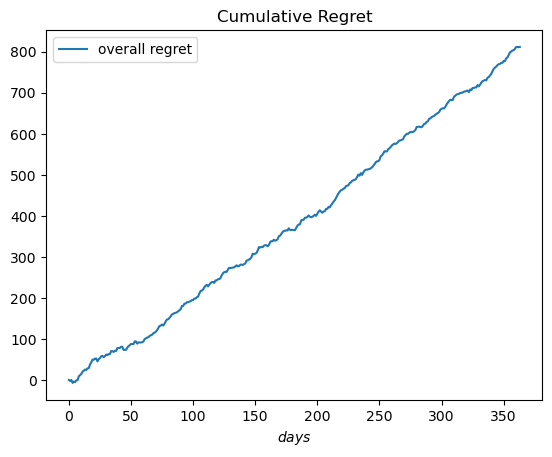

In [45]:
clairprofit = np.array(clairvoyant_profits)
bidagentprofit = np.array(bidding_agent_profits)
print(clairprofit.shape)
print(bidagentprofit.shape)

cumulative_regret = np.cumsum(clairprofit[1:]-bidagentprofit)

plt.figure()
plt.plot(cumulative_regret, label="overall regret")
plt.legend()
plt.title('Cumulative Regret')
plt.xlabel('$days$')
plt.show();


In [122]:
print(clairvoyant_sales*p_t)
print(np.sum(clairvoyant_payments))
print(my_valuation_t)
print(clairvoyant_payments[clairvoyant_payments>=my_valuation_t])
print(f'true count in clairvoyant payments: {np.sum(clairvoyant_payments>=my_valuation_t)}')

371.84210526315786
1999.4222989827754
0.1623386295645866
[0.16252068 0.85136408 0.6866651  ... 0.1625343  0.1633252  0.99729805]
true count in clairvoyant payments: 2877


In [149]:
utility = (my_valuation_t-bidding_env.m_t)*(my_valuation_t>=bidding_env.m_t)
print(utility)
sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
print(utility[sorted_round_utility])
print(np.count_nonzero(utility))
print(np.count_nonzero(utility[sorted_round_utility]))
print(np.count_nonzero(clairvoyant_bids))

[-0.         -0.         -0.         ...  0.07404293 -0.
 -0.        ]
[ 0.14915633  0.14464129  0.14334241 ... -0.         -0.
 -0.        ]
272
272
272


In [34]:
# why first is higher than latter
# bidding_agent_profit = number_sale_t*p_t-np.sum(my_payments[0,:])
# clairvoyant_profit = clairvoyant_sales*p_t - np.sum(clairvoyant_payments)
print(f'At day {day} :\tprice_t = {p_t:.4f}, with estimated purchase probability = {purchase_probability_t:.4f}\
          \n\t\tmy valuation = {my_valuation_t:.4f}, won {int(n_customers_t)}/{n_users} auctions, with a mean bid of {scaled_payed_bid_per_user:.4f} \
          \n\t\twe sold {number_sale_t}/{int(n_customers_t)} ({number_sale_t/n_customers_t*100:.2f}%) products, for a total net profit of {bidding_agent_profit:.4f}\
          \n\t\tclairvoyant sale : {clairvoyant_sales}/{clairvoyant_customers} ({clairvoyant_sales/clairvoyant_customers*100:.2f}%), for a total net profit of {clairvoyant_profit:.4f}\n')

print(p_t*conversion_probabilities[pricing_agent.a_t])

print("Total profit :")
print(bidding_agent_profit)
print(clairvoyant_profit)

print("Total revenue :")
print(number_sale_t*p_t)
print(clairvoyant_sales*p_t)

print("Total payment :")
print(np.sum(my_payments[0,:]))
print(np.sum(clairvoyant_payments))

print("Total won auction :")
print(np.count_nonzero(my_payments[0,:]))
print(np.count_nonzero(clairvoyant_payments))

print("Mean payed bid :")
print(np.sum(my_payments[0,:])/np.count_nonzero(my_payments[0,:]))
print(np.sum(clairvoyant_payments)/np.count_nonzero(clairvoyant_payments))

print("agent")
for idx, el in enumerate(my_payments[0,:]!=0):
    if el and idx < 500:
        print(f'{idx} : {my_payments[0,:][idx]}')

print("clairvoyant")
for idx, el in enumerate(clairvoyant_payments!=0):
    if el and idx < 500:
        print(f'{idx} : {clairvoyant_payments[idx]}')

# At day 3 :	price_t = 0.5263, with estimated purchase probability = 0.35157362546534565          
# 		my valuation = 0.1850, won 150/10000 auctions, with a mean bid of 0.0896           
# 		we sold 48/150 (32.00%) products, for a total net profit of 11.8171          
# 		clairvoyant sale : 111/355 (31.27%), for a total net profit of 13.2371

ZeroDivisionError: division by zero

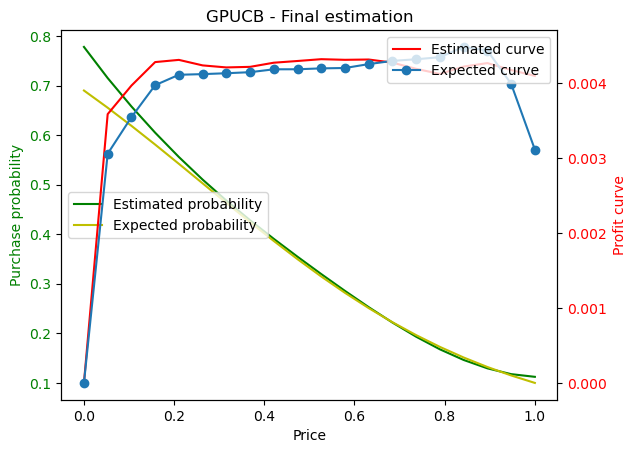

In [23]:
estimated_purchase_probability = (pricing_agent.mu_t + pricing_agent.beta(pricing_agent.t) * pricing_agent.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * pricing_agent.arms - pricing_agent.average_bidding_costs
ucbs = estimated_profits_per_customer * pricing_agent.average_customer_percentages

# Purchase probability, given by model and estimated by agent
fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Profit curve
ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent.arms - pricing_agent.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, pricing_agent.average_customer_percentages*(conversion_probabilities*pricing_agent.arms - pricing_agent.average_bidding_costs), 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='upper right')

plt.title('GPUCB - Final estimation')
plt.show()

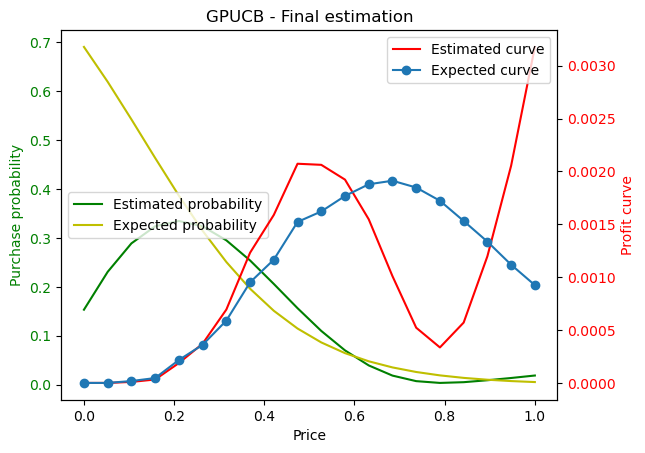

In [54]:
estimated_purchase_probability = (pricing_agent.mu_t + pricing_agent.beta(pricing_agent.t) * pricing_agent.sigma_t)
estimated_profits_per_customer = estimated_purchase_probability * (pricing_agent.arms - pricing_agent.average_bidding_costs)
ucbs = estimated_profits_per_customer * pricing_agent.average_customer_percentages

prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)

fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()
# ax2.plot(prices, pricing_agent.arms - pricing_agent.average_bidding_costs, 'o-', label='profit')
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, conversion_probabilities*(pricing_agent.arms - pricing_agent.average_bidding_costs)*pricing_agent.average_customer_percentages, 'o-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='upper right')

plt.title('GPUCB - Final estimation')
plt.show()

In [24]:
pricing_agent.average_customer_percentages

array([1.        , 0.16741667, 0.10231   , 0.08116923, 0.06854375,
       0.058545  , 0.05341739, 0.04986154, 0.04854643, 0.04757931,
       0.04758276, 0.04829286, 0.05031923, 0.051975  , 0.05425909,
       0.05802   , 0.06257222, 0.0689125 , 0.07323333, 0.07980714])

In [58]:
print(pricing_agent.arms)
print(pricing_agent.average_bidding_costs)
print(pricing_agent.arms - pricing_agent.average_bidding_costs)
print(estimated_purchase_probability)
print(estimated_profits_per_customer)
print(pricing_agent.average_customer_percentages)
print(ucbs)

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
[0.5329363  0.53466182 0.53943211 0.53714032 0.53632192 0.54024723
 0.53993253 0.53407122 0.53553273 0.53056244 0.5365128  0.53562107
 0.53600058 0.53539605 0.53679792 0.53727782 0.53525437 0.53414657
 0.53573095 0.53511304]
[-0.5329363  -0.48203024 -0.43416895 -0.37924559 -0.32579561 -0.27708933
 -0.22414305 -0.16565017 -0.1144801  -0.05687823 -0.01019701  0.0433263
  0.09557837  0.14881447  0.20004419  0.25219586  0.3068509   0.36059027
  0.41163747  0.46488696]
[0.69422185 0.61662259 0.54075991 0.46605002 0.39335318 0.32438209
 0.26106741 0.20504163 0.15733455 0.11829011 0.08764497 0.06467628
 0.04833657 0.03733954 0.03021956 0.02543335 0.02158249 0.01780004
 0.01427376 0.01279552]
[-0.36997602 -0.29723073 -0.23478116 -0.17674741 -0.12815274 -0.08988282
 -0.0585

In [27]:
print(estimated_purchase_probability)


[0.16135475 0.23146012 0.28208459 0.30989582 0.31504684 0.30033482
 0.2702053  0.2298321  0.18440892 0.1386781  0.09663816 0.06134378
 0.03474152 0.01754992 0.0092557  0.00832338 0.01268392 0.02048462
 0.03097681 0.04532992]


In [28]:
print(pricing_agent.mu_t)

[0.14069885 0.22009392 0.2750187  0.30510908 0.31181495 0.29818898
 0.26852609 0.22789495 0.18161556 0.1347417  0.09160528 0.05546935
 0.02832208 0.01082486 0.00240851 0.00149437 0.00580344 0.01270964
 0.01959178 0.02414342]


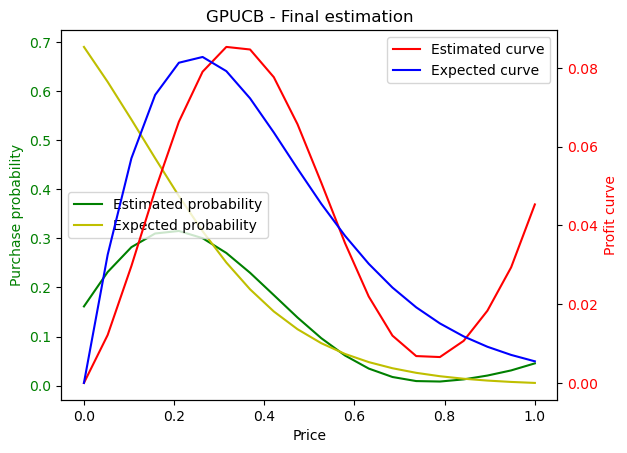

In [21]:
estimated_purchase_probability = (pricing_agent.mu_t + pricing_agent.beta(pricing_agent.t) * pricing_agent.sigma_t)
ucbs = estimated_purchase_probability * (pricing_agent.arms - pricing_agent.average_bidding_costs)

prices = np.linspace(scaled_min_price, scaled_max_price, price_discretization)
conversion_probabilities = StochasticPricingEnvironment.generate_probability(model, alpha, beta, prices)

fig, ax1 = plt.subplots()
ax1.plot(prices, estimated_purchase_probability, 'g-', label='Estimated probability')
ax1.plot(prices, conversion_probabilities, 'y-', label='Expected probability')
ax1.set_xlabel('Price')
ax1.set_ylabel('Purchase probability', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()
ax2.plot(prices, ucbs, 'r-', label='Estimated curve')
ax2.plot(prices, conversion_probabilities*prices, 'b-', label='Expected curve')
ax2.set_ylabel('Profit curve', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='center left')
ax2.legend(loc='upper right')

plt.title('GPUCB - Final estimation')
plt.show()

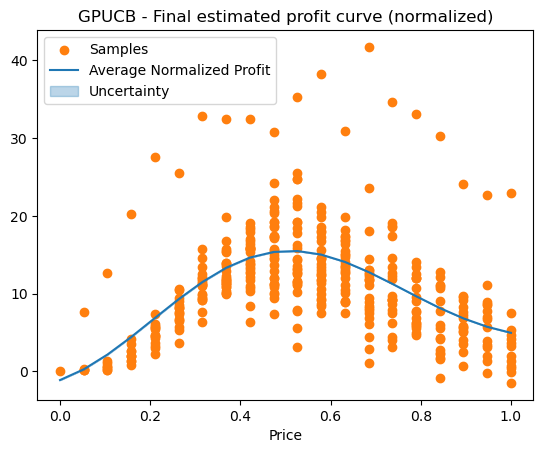

In [103]:
price_hist = pricing_agent.action_hist
profits = pricing_agent.reward_hist

gp = RBFGaussianProcess(scale=scale)
gp.fit(price_hist, profits)
mu, sigma = gp.predict(prices)
plt.scatter(price_hist, profits, label='Samples', color='C1')
plt.plot(prices, mu, label='Average Normalized Profit')
# plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(prices, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

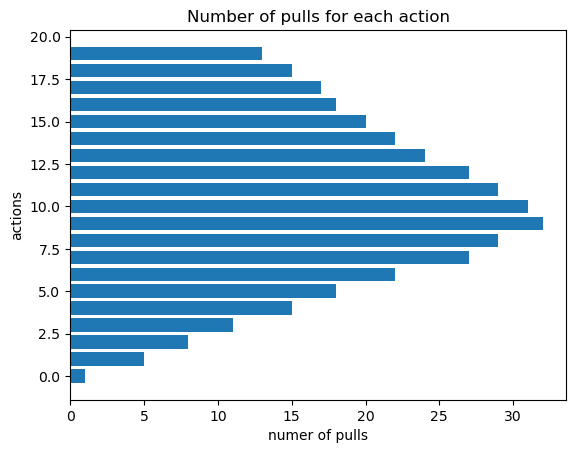

In [111]:
plt.figure()
plt.barh(np.arange(price_discretization), pricing_agent.N_pulls)
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.title('Number of pulls for each action')
plt.show();